# Linear Regression with Auto Data

*Pranav Shah* 

## Introduction

In this assignment we'll conduct linear regression on cars data with price or some transformation of price as the labeled data. We'll examine three methodologies to avoid overfitting and over parameterizing data - 1) stepwise regression, 2) Singular Value Decomposition, and 3) Ridge and Lasso Regularization with Elastic Net. We'll also examine the performance of these models with summary model statistics and plots. Note that we will be examining model performance on the same dataset used to create the model, which has its own biases, but will do so as an exercise.   


## Summary

After examining the three techniques, all three seem to have similar performance to each other as judged by the adjusted R^2. However, looking at the behavior of the residuals, the elastic net seems to have better residual behavior than the other two methods, thus would be preferrable given the known information at hand. Keep in mind we are making these assesments on the training data - the same used to build the model - and not on testing data or new observational data. The discussion below will walk through all three techniques.  

## Prepare Data

Our first step in our process of examining price of autos is to get and prepare the auto data so that it can be consumed by regression functions and manipulated into a model matrix.

### Get data

In [1]:
# get data
read.auto = function(file = 'Automobile price data _Raw_.csv'){
  ## Read the csv file
  auto.price <- read.csv(file, header = TRUE, 
                         stringsAsFactors = FALSE)
  
  ## Coerce some character columns to numeric
  numcols <- c('price', 'bore', 'stroke', 'horsepower', 'peak.rpm')
  auto.price[, numcols] <- lapply(auto.price[, numcols], as.numeric)
  
  ## Remove cases or rows with missing values. In this case we keep the 
  ## rows which do not have nas. 
  auto.price[complete.cases(auto.price), ]
}
auto.price <- read.auto()

str(auto.price)

Warning message in lapply(auto.price[, numcols], as.numeric):
"NAs introduced by coercion"Warning message in lapply(auto.price[, numcols], as.numeric):
"NAs introduced by coercion"Warning message in lapply(auto.price[, numcols], as.numeric):
"NAs introduced by coercion"Warning message in lapply(auto.price[, numcols], as.numeric):
"NAs introduced by coercion"Warning message in lapply(auto.price[, numcols], as.numeric):
"NAs introduced by coercion"

'data.frame':	195 obs. of  26 variables:
 $ symboling        : int  3 3 1 2 2 2 1 1 1 2 ...
 $ normalized.losses: chr  "?" "?" "?" "164" ...
 $ make             : chr  "alfa-romero" "alfa-romero" "alfa-romero" "audi" ...
 $ fuel.type        : chr  "gas" "gas" "gas" "gas" ...
 $ aspiration       : chr  "std" "std" "std" "std" ...
 $ num.of.doors     : chr  "two" "two" "two" "four" ...
 $ body.style       : chr  "convertible" "convertible" "hatchback" "sedan" ...
 $ drive.wheels     : chr  "rwd" "rwd" "rwd" "fwd" ...
 $ engine.location  : chr  "front" "front" "front" "front" ...
 $ wheel.base       : num  88.6 88.6 94.5 99.8 99.4 ...
 $ length           : num  169 169 171 177 177 ...
 $ width            : num  64.1 64.1 65.5 66.2 66.4 66.3 71.4 71.4 71.4 64.8 ...
 $ height           : num  48.8 48.8 52.4 54.3 54.3 53.1 55.7 55.7 55.9 54.3 ...
 $ curb.weight      : int  2548 2548 2823 2337 2824 2507 2844 2954 3086 2395 ...
 $ engine.type      : chr  "dohc" "dohc" "ohcv" "ohc" ...
 $ num.o

### Remove symboling and normalized losses 

These varibles need to be removed prior to inputting data into functions.

In [2]:
# remove symbolizing and normalized losses
library(dplyr)
auto.price <- auto.price %>% dplyr::select(-normalized.losses,-symboling)


Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union



### Scale numerical data

In order to correctly evaluate a features' regression coefficients on the same scale, we need to scale the data with z-score transformation.

In [3]:
nums <- sapply(auto.price, is.numeric)
auto.price.scaled <- auto.price
auto.price.scaled[, nums] <- lapply(auto.price[,nums], scale)
auto.price.scaled[, !nums] <- lapply(auto.price[,!nums], as.factor)

str(auto.price.scaled)

'data.frame':	195 obs. of  24 variables:
 $ make             : Factor w/ 21 levels "alfa-romero",..: 1 1 1 2 2 2 2 2 2 3 ...
 $ fuel.type        : Factor w/ 2 levels "diesel","gas": 2 2 2 2 2 2 2 2 2 2 ...
 $ aspiration       : Factor w/ 2 levels "std","turbo": 1 1 1 1 1 1 1 1 2 1 ...
 $ num.of.doors     : Factor w/ 3 levels "?","four","two": 3 3 3 2 2 3 2 2 2 3 ...
 $ body.style       : Factor w/ 5 levels "convertible",..: 1 1 3 4 4 4 4 5 4 4 ...
 $ drive.wheels     : Factor w/ 3 levels "4wd","fwd","rwd": 3 3 3 2 1 2 2 2 2 3 ...
 $ engine.location  : Factor w/ 2 levels "front","rear": 1 1 1 1 1 1 1 1 1 1 ...
 $ wheel.base       : num [1:195, 1] -1.6791 -1.6791 -0.717 0.1474 0.0821 ...
  ..- attr(*, "scaled:center")= num 98.9
  ..- attr(*, "scaled:scale")= num 6.13
 $ length           : num [1:195, 1] -0.437 -0.437 -0.245 0.188 0.188 ...
  ..- attr(*, "scaled:center")= num 174
  ..- attr(*, "scaled:scale")= num 12.5
 $ width            : num [1:195, 1] -0.838 -0.838 -0.181 0.147 0.241 

Examing the structure of the auto data after applying scaling, we see that integer and numerical columns were transformed to a common scale. Addtionally, the character columns are transformed to factors.

### Create Model Matrix

Next we will construct a model matrix, which will be used in the singular value decompistition and ridge/lasso regression functions. The model matrix constructs a column for each feature. For categorical features, dummy variables for all levels are created. Additionally, we igonore creating an intercept so that all factor levels are expressed as individual dummy variables.

In [4]:
mod.auto <- model.matrix(price~. -1, data = auto.price.scaled)

In [5]:
str(data.frame(mod.auto))

'data.frame':	195 obs. of  60 variables:
 $ makealfa.romero       : num  1 1 1 0 0 0 0 0 0 0 ...
 $ makeaudi              : num  0 0 0 1 1 1 1 1 1 0 ...
 $ makebmw               : num  0 0 0 0 0 0 0 0 0 1 ...
 $ makechevrolet         : num  0 0 0 0 0 0 0 0 0 0 ...
 $ makedodge             : num  0 0 0 0 0 0 0 0 0 0 ...
 $ makehonda             : num  0 0 0 0 0 0 0 0 0 0 ...
 $ makeisuzu             : num  0 0 0 0 0 0 0 0 0 0 ...
 $ makejaguar            : num  0 0 0 0 0 0 0 0 0 0 ...
 $ makemazda             : num  0 0 0 0 0 0 0 0 0 0 ...
 $ makemercedes.benz     : num  0 0 0 0 0 0 0 0 0 0 ...
 $ makemercury           : num  0 0 0 0 0 0 0 0 0 0 ...
 $ makemitsubishi        : num  0 0 0 0 0 0 0 0 0 0 ...
 $ makenissan            : num  0 0 0 0 0 0 0 0 0 0 ...
 $ makepeugot            : num  0 0 0 0 0 0 0 0 0 0 ...
 $ makeplymouth          : num  0 0 0 0 0 0 0 0 0 0 ...
 $ makeporsche           : num  0 0 0 0 0 0 0 0 0 0 ...
 $ makesaab              : num  0 0 0 0 0 0 0 0 0 0 ...
 $ make

When looking at the model matrix, there is an absence of the intercept. Additionally, make has all 21 levels, but the other factors show #levels - 1 dummy columns. For instance, fuel type only has a feature for gas, but has two factors - gas and diesel. The representation is still valid where 0 represents diesel. I'm not sure why the model.matrix function creates dummies for all levels with the first factor variable, but subtracts one for each subsequent. Maybe it is trying to reduce redundancy. 

## Stepwise Regression

Here we will run a stepwise linear regression with unscaled price as the target variable.

### Linear regression with all features

As a baseline we will run a linear regression with all the features on the un-scaled (real) price. From the summary, we see that the adjusted R^2 is about .9527, but we see some decrease in residuals price increases, and an upward trajectory of the standardized residuals. Additionally, the Q-Q plot seems to have some tail off in the upper quartiles. We'll try to improve on the model by reducing the feature set with stepwise regression.


Call:
lm(formula = price.real ~ ., data = auto.price.scaled %>% dplyr::select(-log.price, 
    -price))

Residuals:
    Min      1Q  Median      3Q     Max 
-3512.5  -916.1     0.0   804.9  8399.5 

Coefficients: (3 not defined because of singularities)
                       Estimate Std. Error t value Pr(>|t|)    
(Intercept)             31908.9     6808.7   4.687 6.59e-06 ***
makeaudi                  123.9     2239.3   0.055 0.955960    
makebmw                  5094.7     2331.4   2.185 0.030554 *  
makechevrolet           -5341.9     2287.0  -2.336 0.020945 *  
makedodge               -6049.2     1878.5  -3.220 0.001598 ** 
makehonda               -3118.2     2207.5  -1.413 0.160029    
makeisuzu               -3885.0     2474.9  -1.570 0.118760    
makejaguar              -1492.2     2800.8  -0.533 0.595036    
makemazda               -2829.3     1709.1  -1.655 0.100107    
makemercedes-benz        1512.5     2515.2   0.601 0.548599    
makemercury             -4545.6     2950.

Warning message:
"not plotting observations with leverage one:
  18, 29, 43, 44, 47, 119"

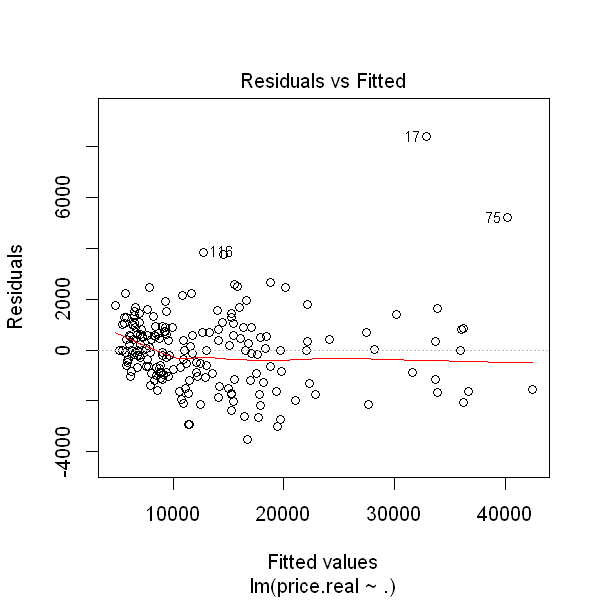

Warning message:
"not plotting observations with leverage one:
  18, 29, 43, 44, 47, 119"

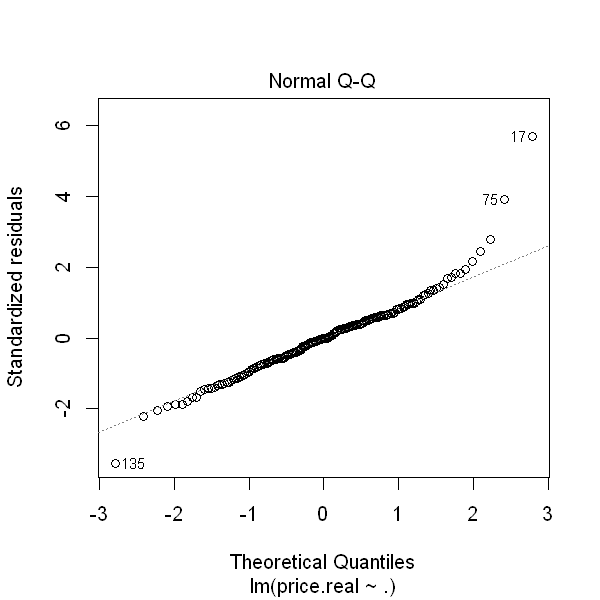

Warning message in sqrt(crit * p * (1 - hh)/hh):
"NaNs produced"Warning message in sqrt(crit * p * (1 - hh)/hh):
"NaNs produced"

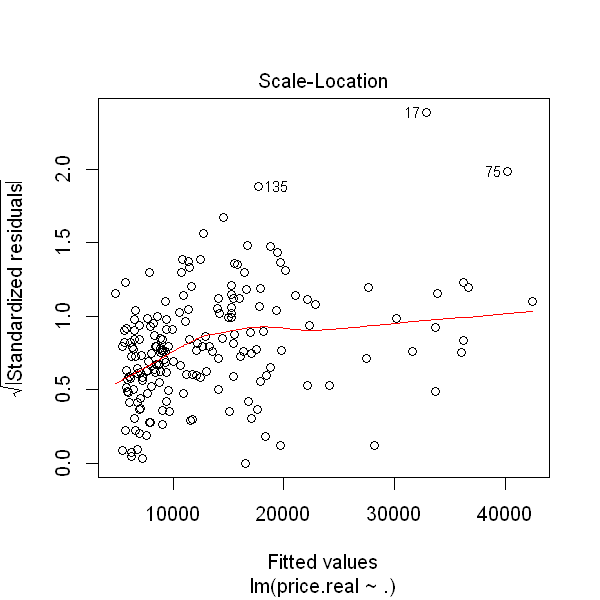

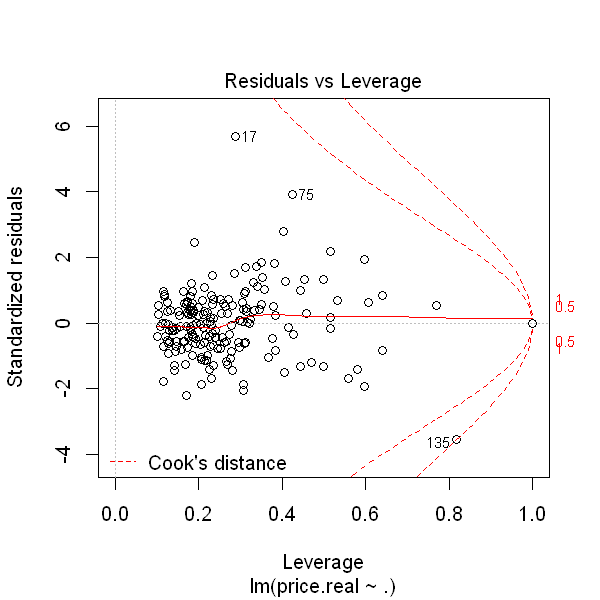

In [12]:
auto.price.scaled$price.real <- auto.price$price
auto.price.scaled$log.price <- log(auto.price$price)

require(repr)
options(repr.plot.width=5, repr.plot.height=5)

lm.auto <- lm(price.real ~ ., data = auto.price.scaled %>% dplyr::select(-log.price, -price))
summary(lm.auto)
plot(lm.auto)

### StepAIC 

Next we'll use a stepwise regression method to converge and select features that have the most influence on price. In stepwise regression in both directions, features are removed and added in an iterative process based which minimizes the  AIC (Akanie Information Criterion).

The following features remain in the model:

    make + aspiration + body.style + wheel.base + 
    length + width + height + curb.weight + engine.type + num.of.cylinders + 
    engine.size + fuel.system + bore + stroke + compression.ratio + 
    peak.rpm + highway.mpg
    
The following features were removed:
    
- engine.location	
- fuel.type	
- drive.wheels
- num.of.doors
- city.mpg
- horsepower

In terms of performance the final model resulted in a slight increase in adjusted R^2 (~ 0.002), which suggests the model has similar performance as the baseline linear regression, but with fewer features. The RSME decreased from the baseline. The residuals still exhibit slight instability as in the baseline linear regression. The QQ plot shows near normal distribution of the residuals, except for the upper tail, and the standardized residuals increase with fitted values or score. These plots show some evidence there is heteroscadicity in price. 

Start:  AIC=2959.22
price.real ~ make + fuel.type + aspiration + num.of.doors + body.style + 
    drive.wheels + engine.location + wheel.base + length + width + 
    height + curb.weight + engine.type + num.of.cylinders + engine.size + 
    fuel.system + bore + stroke + compression.ratio + horsepower + 
    peak.rpm + city.mpg + highway.mpg


Step:  AIC=2959.22
price.real ~ make + fuel.type + aspiration + num.of.doors + body.style + 
    drive.wheels + wheel.base + length + width + height + curb.weight + 
    engine.type + num.of.cylinders + engine.size + fuel.system + 
    bore + stroke + compression.ratio + horsepower + peak.rpm + 
    city.mpg + highway.mpg


Step:  AIC=2959.22
price.real ~ make + aspiration + num.of.doors + body.style + 
    drive.wheels + wheel.base + length + width + height + curb.weight + 
    engine.type + num.of.cylinders + engine.size + fuel.system + 
    bore + stroke + compression.ratio + horsepower + peak.rpm + 
    city.mpg + highway.mpg

                

Step,Df,Deviance,Resid. Df,Resid. Dev,AIC
,NA,NA,138,423428758,2959.225
- engine.location,0,1.072884e-06,138,423428758,2959.225
- fuel.type,0,1.490116e-06,138,423428758,2959.225
- drive.wheels,2,1.393915e+06,140,424822673,2955.866
- num.of.doors,2,1.448704e+06,142,426271377,2952.529
- city.mpg,1,6.447088e+04,143,426335848,2950.559
- horsepower,1,6.586857e+05,144,426994533,2948.860



Call:
lm(formula = price.real ~ make + aspiration + body.style + wheel.base + 
    length + width + height + curb.weight + engine.type + num.of.cylinders + 
    engine.size + fuel.system + bore + stroke + compression.ratio + 
    peak.rpm + highway.mpg, data = auto.price.scaled %>% dplyr::select(-log.price, 
    -price))

Residuals:
    Min      1Q  Median      3Q     Max 
-3458.8 -1022.1     0.0   767.4  8238.9 

Coefficients: (1 not defined because of singularities)
                        Estimate Std. Error t value Pr(>|t|)    
(Intercept)             18092.95    3741.95   4.835 3.38e-06 ***
makeaudi                   88.46    2125.96   0.042 0.966868    
makebmw                  5069.21    2242.38   2.261 0.025281 *  
makechevrolet           -5492.31    2126.31  -2.583 0.010790 *  
makedodge               -6377.70    1775.80  -3.591 0.000450 ***
makehonda               -3420.00    2064.42  -1.657 0.099770 .  
makeisuzu               -4022.60    2351.20  -1.711 0.089258 .  
makeja

Warning message:
"not plotting observations with leverage one:
  18, 29, 43, 44, 47, 119"

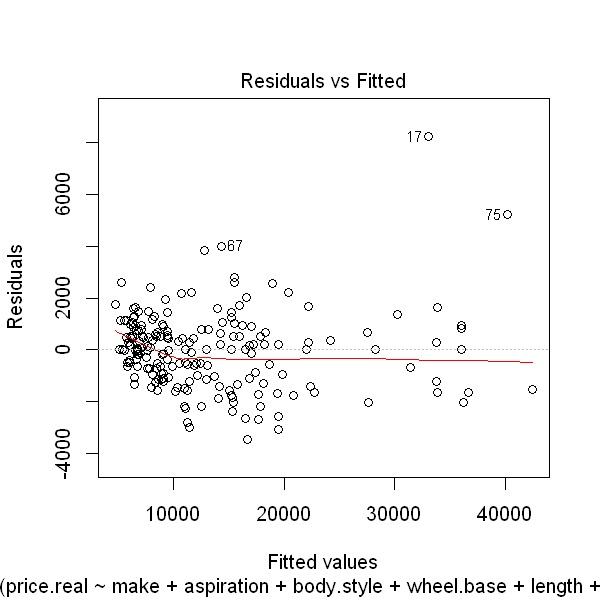

Warning message:
"not plotting observations with leverage one:
  18, 29, 43, 44, 47, 119"

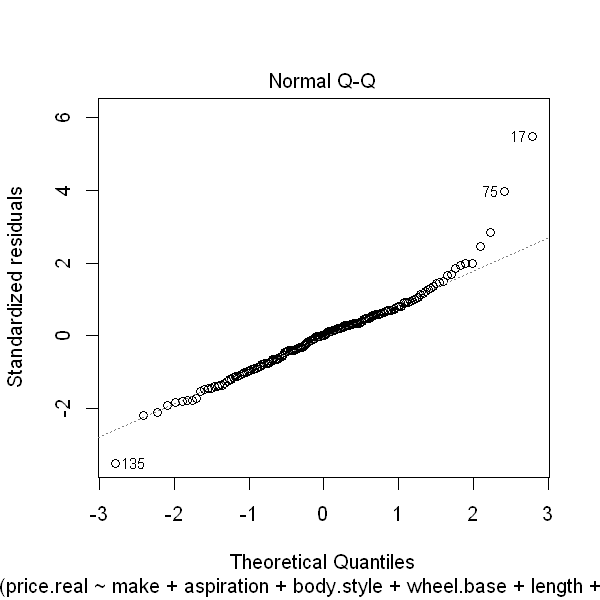

Warning message in sqrt(crit * p * (1 - hh)/hh):
"NaNs produced"Warning message in sqrt(crit * p * (1 - hh)/hh):
"NaNs produced"

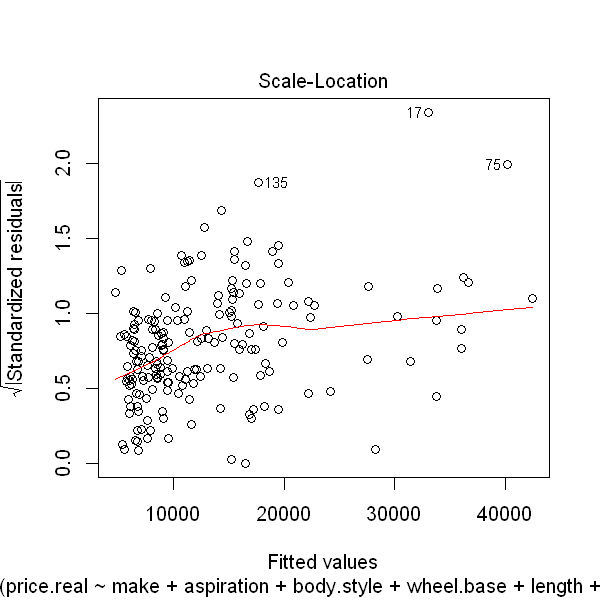

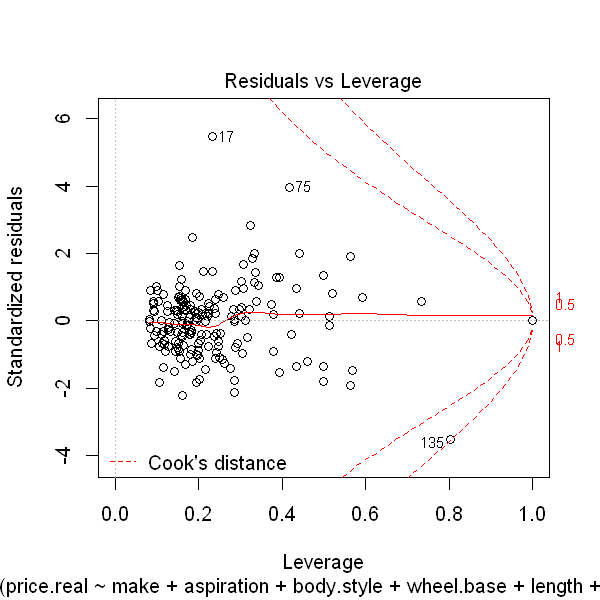

In [13]:
library(MASS)

lm.auto.step <- stepAIC(lm.auto, direction = "both")
lm.auto.step$anova
summary(lm.auto.step)
plot(lm.auto.step)

## Singular Value Decomposition

Stepwise regression can be very computationally inefficient at scale. The SVD attempts to assign coefficients and wieghts to all features in a stabalized model matrix. Our goal is to minimize mean squared error with these feature coefficients. 

First we must check to see if the svd of model matrix is rank deficient, or if any of the singular values are essentially zero and not of the same magnitude as the other values. From the plots below of the singular values and log singular values we can see that the last 3 values are near zero and not the same magnitude has the other singular values. This suggests that the matrix is rank deficient.

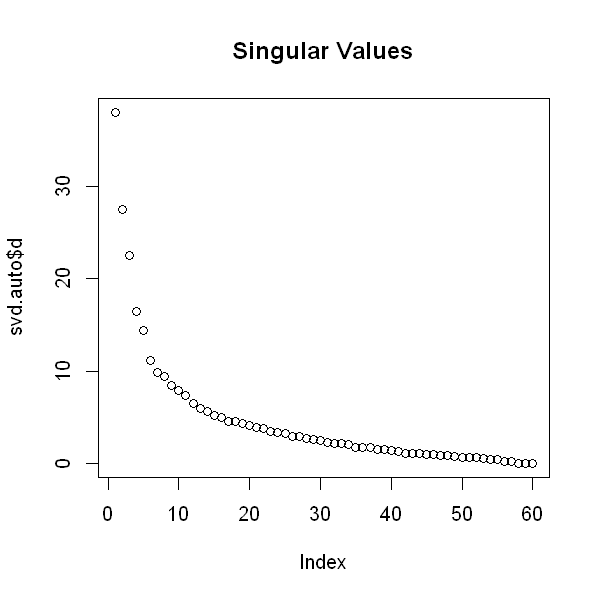

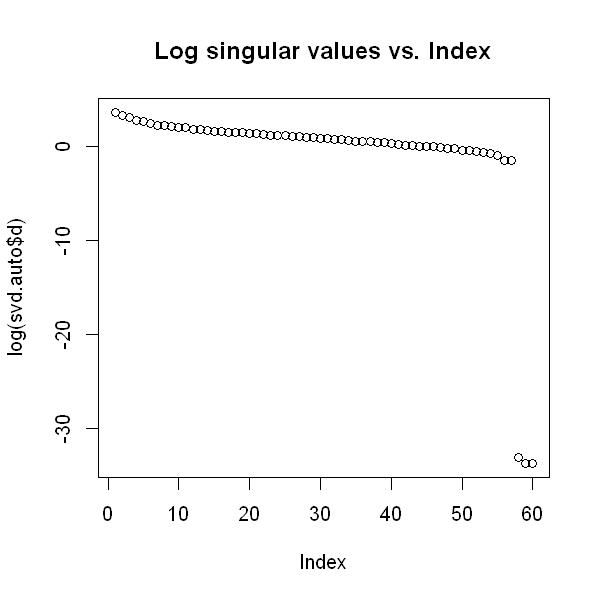

In [15]:
svd.auto <- svd(mod.auto)
plot(svd.auto$d, main = "Singular Values")
plot(log(svd.auto$d), main = "Log singular values vs. Index")

Next we'll set the singular values that we've identified as possible cause of rank deficiency to zero and calculate the inverse singular matrix. Then we'll calculate the pseudo inverse matrix.

Note: That here we only show the last three values in the singular vector set to zero, but we tested several other possible values that didn't result in a significantly better model.

In [20]:
# get the inverse of the singular matrix and set "outliers to zero"
dtrim <- rep(0, length(svd.auto$d))
dtrim[1:57] <- 1/svd.auto$d[1:57]
dM <- diag(dtrim)
# pseudo inverse matrix
InvM <- svd.auto$v %*% dM %*% t(svd.auto$u)
# check psuedo inverse times model matrix
invMM <- InvM %*% mod.auto

Next we calculate the model coeffiecents with the psuedo inverse matrix. 

Note: Here we show scaled price times the pseudo inverse, but we also tried real price and log price which resulted in strange residual values. We'll continue with the scaled price.

In [21]:
bM <- InvM %*% auto.price.scaled$price

Next, we'll calculate the score (predicted value) and residuals from the model matrix and coefficients.

In [22]:
auto.results.svd <- data.frame(actual = auto.price.scaled$price)
auto.results.svd$score <- mod.auto %*% bM + mean(auto.price.scaled$price)
auto.results.svd$resids <- auto.results.svd$score - auto.results.svd$actual

Finally, we can plot the fitted values (scores) and the residuals to understand the performance.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


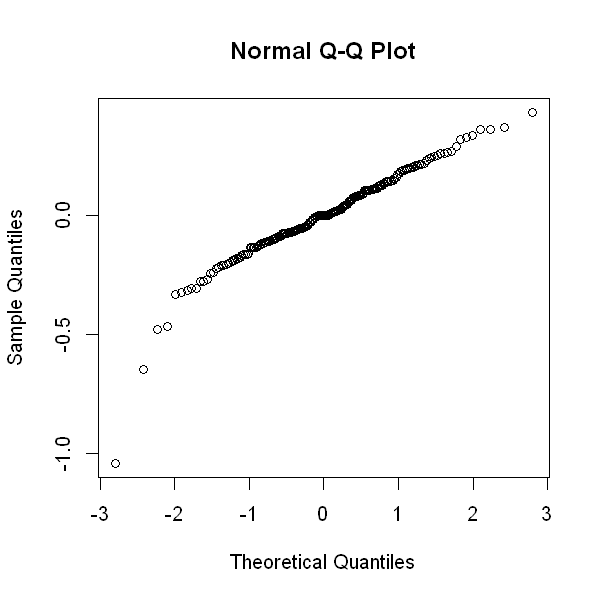

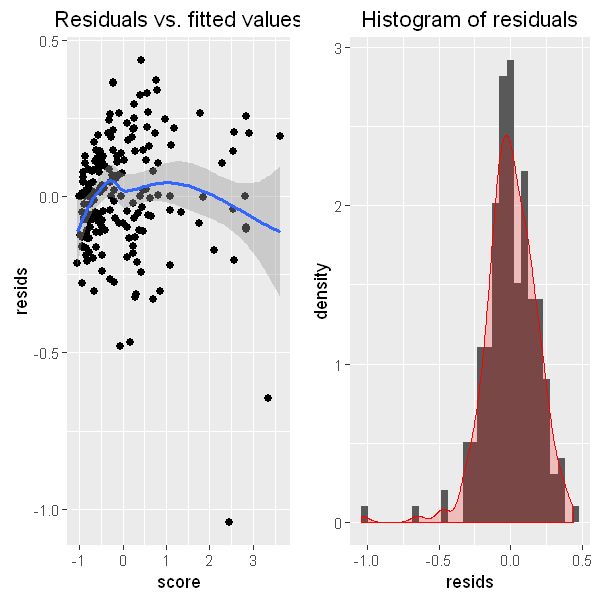

SSE = 187.476121771932 
SSR = 6.52387822806849 
SST = 194 
RMSE = 0.971378869284619 
Adjusted R^2 = 0.951314341581578 


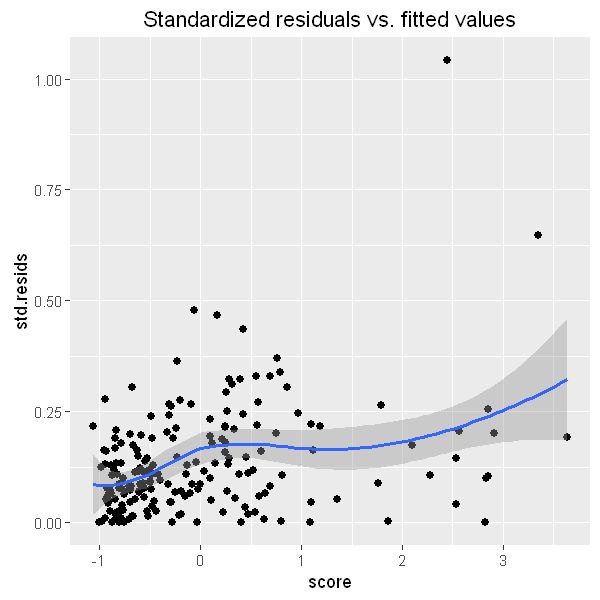

In [23]:
plot.svd.reg <- function(df, k = 4){
  require(ggplot2)
  require(gridExtra)
  
  p1 <- ggplot(df) + 
    geom_point(aes(score, resids), size = 2) + 
    stat_smooth(aes(score, resids)) +
    ggtitle('Residuals vs. fitted values')
  
  p2 <- ggplot(df, aes(resids)) +
    geom_histogram(aes(y = ..density..)) +
    geom_density(color = 'red', fill = 'red', alpha = 0.2) +
    ggtitle('Histogram of residuals')
  
  qqnorm(df$resids)
  
  grid.arrange(p1, p2, ncol = 2)
  
  df$std.resids = sqrt((df$resids - mean(df$resids))^2)  
  
  p3 = ggplot(df) + 
    geom_point(aes(score, std.resids), size = 2) + 
    stat_smooth(aes(score, std.resids)) +
    ggtitle('Standardized residuals vs. fitted values')
  print(p3) 
  
  n = nrow(df)
  Ybar = mean(df$actual)
  SST <- sum((df$actual - Ybar)^2)
  SSR <- sum(df$resids * df$resids)
  SSE = SST - SSR
  cat(paste('SSE =', as.character(SSE), '\n'))
  cat(paste('SSR =', as.character(SSR), '\n'))
  cat(paste('SST =', as.character(SSE + SSR), '\n'))
  cat(paste('RMSE =', as.character(SSE/(n - 2)), '\n'))
  
  adjR2  <- 1.0 - (SSR/SST) * ((n - 1)/(n - k - 1))
  cat(paste('Adjusted R^2 =', as.character(adjR2)), '\n')
}

plot.svd.reg(auto.results.svd, k = 60)

From the above plots and summary statistics we see there is quite a bit of instability in the standardized and regular residuals vs score and fitted values. The residuals seem to be mostly normally distributed, but with some skew from the histogram and lagging tails in the Q-Q plot. The standardized residuals increase with score, which suggests some heteroscadicity. Even though the Adjusted R^2 is similar (0.9513) to our previous stepwise attempt, this model seems to exhibit some instability. 

## Ridge and Lasso with Elastic Net

We can also apply penalities to coefficients with L2 (ridge) and L1 (lasso) to stabalize the inverse function. Using the glmnet function with alpha set to 0.5 (half of the wieght is set to the ridge and half to the lasso), we can test several lambda values - the penalization value. We'll use the model matrix previously developed and run a linear regression with penalties on log price as the target. 

When evaluating these functions across a variety of lambas, we can plot both log lambdas and deviance against the coefficient weights. Also, the top x-axis shows the number of non-zero coefficients. The first plot shows that with a log lambda set to 0 (or max penalty) all the coefficients are zero and this would fail to make meaningful predictions since all predictions would be zero and biased. With a log lambda set to the minimum tested, all coefficients have values but increases the deviance or variation significantly. The best choice of lambda will balance the bias and variance. 

Loading required package: glmnet
Warning message:
“package ‘glmnet’ was built under R version 3.2.4”Loading required package: Matrix
Warning message:
“package ‘Matrix’ was built under R version 3.2.5”Loading required package: foreach
Loaded glmnet 2.0-5



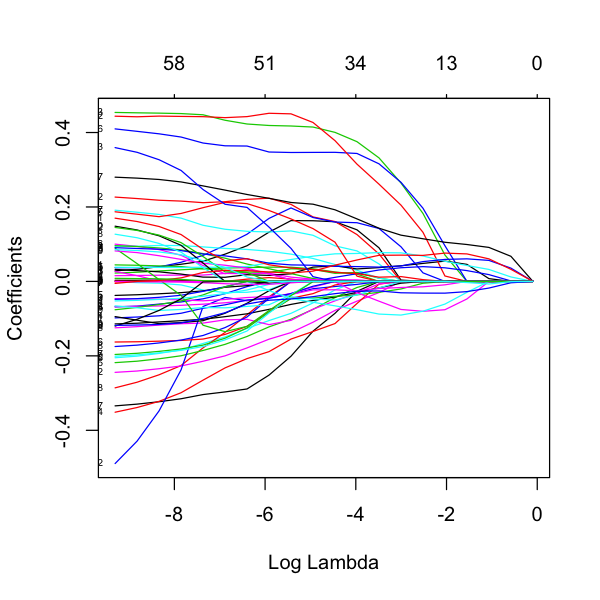

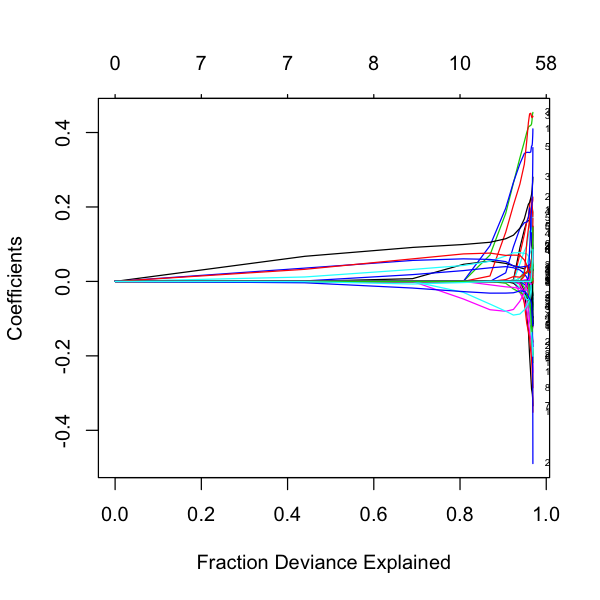

In [71]:
require(glmnet)

b <- auto.price.scaled$log.price

auto.ridge.lasso <- glmnet(mod.auto, b, family = 'gaussian', nlambda = 20, alpha = 0.5)
plot(auto.ridge.lasso, xvar = 'lambda', label = TRUE)
plot(auto.ridge.lasso, xvar = 'dev', label = TRUE)

To evaluate the scores and residuals, we can apply specific indicies through the predict function and then plot residuals and calculate performance statistics using plot.svd.reg.

To find the correct lambda, we can start in the middle, where the index = 10 and the coeffeciencts that are not zero is about 34, which came from the first plot above. At this point we can explain a pretty high degree of deviance, well above 0.8 from the second plot above. We can methodically try several values working our way out from the middle to find the best lambda. Going down in the index results in worsening model performance as determined by adjusted R^2. Moving up in the index results improves the model performance, but the incremental increases diminish while adding more parameters to the model. Below is the final result of many attempts to find a set of weighted coefficients that maximized performance yet didn't over-constrain the model. 

`geom_smooth()` using method = 'loess'
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


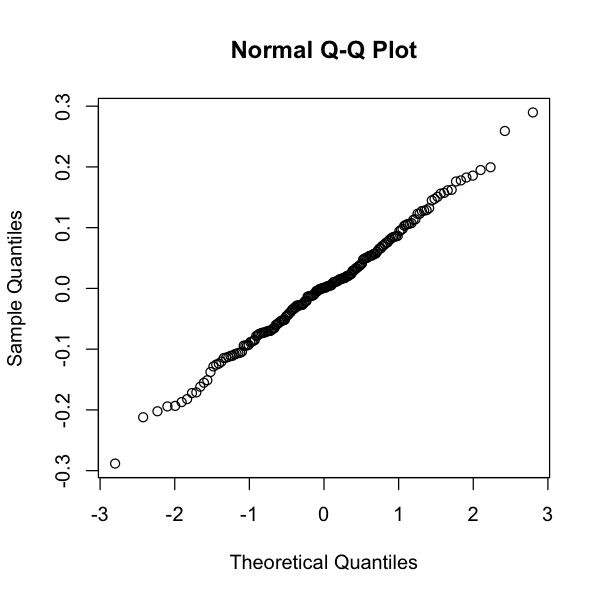

`geom_smooth()` using method = 'loess'


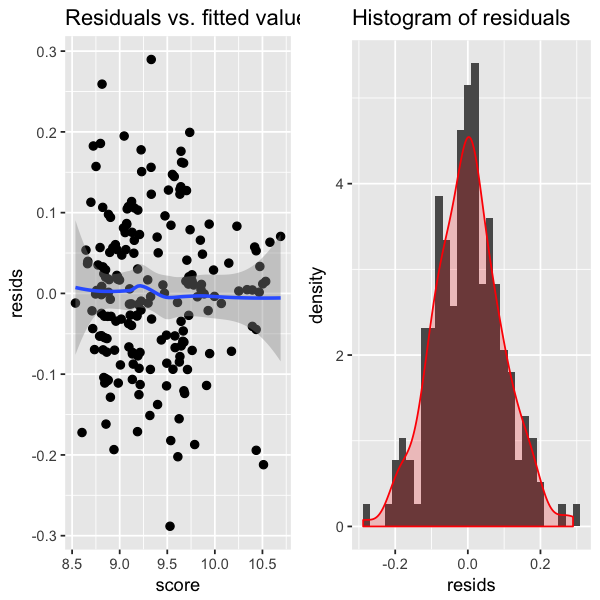

SSE = 48.5415161228196 
SSR = 1.71452098280996 
SST = 50.2560371056296 
RMSE = 0.251510446232226 
Adjusted R^2 = 0.953717132605065 


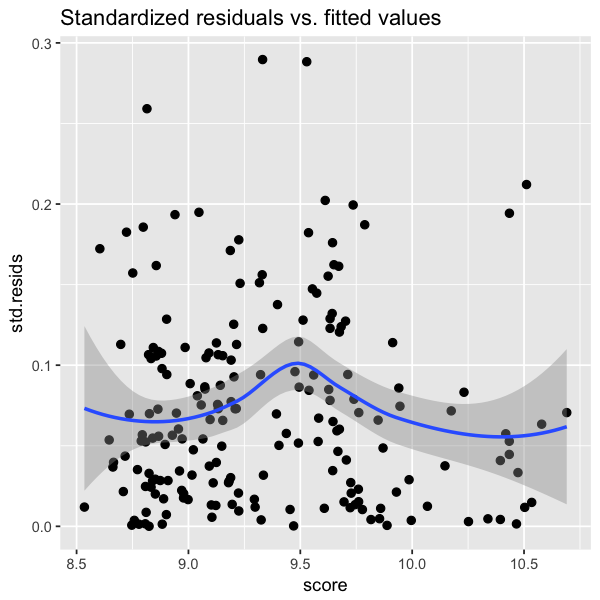

In [72]:
auto.results.eln  <- data.frame(actual = b)
auto.results.eln$score <- predict(auto.ridge.lasso, newx = mod.auto)[,14]
auto.results.eln$resids <- auto.results.eln$score - auto.results.eln$actual

plot.svd.reg(auto.results.eln, k = auto.ridge.lasso$df[14])

From the plots above we can see that the distribution of residuals is nearly normally distributed, except for a couple outliers. The residuals vs. fitted values is stable across all scores. The standardized residuals have an ocillatory shape, which could be a result of a couple of outlier points. Overall this model has better residual performance than the other models. 